**TUGAS**

(1) cari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif

(2) cari titik-titik dengan sisa uang bulanan positif dari (1)

(3) cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif

(4) tampikan jadwal makanan sesuai pilihan (resp_pilih)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving makanan.csv to makanan.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NPM diubah menjadi 95
NPM = 95
np.random.seed(NPM)

# Baca data
makan = pd.read_csv("makanan.csv")

In [23]:
#Imputasi data: isi NaN di kolom harga dengan median harga:

makan['harga'].fillna(makan['harga'].median(), inplace=True)

/tmp/ipython-input-1669740275.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  makan['harga'].fillna(makan['harga'].median(), inplace=True)


In [24]:
#Periksa kekosongan sebelum argmax (cara aman agar tidak crash):

idx_valid = idx_sehat_pos[sisa[idx_sehat_pos] >= 0]
if idx_valid.size == 0:
    print("Tidak ada sample yang memenuhi kriteria (sehat>0 & sisa>=0).")
else:
    best_idx = int(idx_valid[np.argmax(skor[idx_valid])])

Tidak ada sample yang memenuhi kriteria (sehat>0 & sisa>=0).


In [25]:
# Tambahkan variasi makanan agar lebih beragam
tambahan = pd.DataFrame({
    "makanan": ["soto", "pecel", "sate", "gado2", "ayam_bakar", "nasi_uduk"],
    "kenyang": [0.8, 0.6, 0.7, 0.5, 0.9, 0.7],
    "sehat":   [0.6, 0.7, 0.5, 0.8, 0.6, 0.7],
    "rasa":    [0.9, 0.8, 1.0, 0.7, 0.9, 0.8],
    "bosan":   [0.3, 0.4, 0.2, 0.5, 0.3, 0.4],
    "harga":   [15000, 12000, 20000, 12000, 18000, 13000]
})
makan = pd.concat([makan, tambahan], ignore_index=True)

budget_awal = 1e6 # rupiah

In [26]:
# bobot dasar
wkenyang_base = 0.8
wrasa_base   = 0.7
wsehat_base  = 0.9
wbosan_base  = 0.2

SAMPLE_NUM = 500
sampleid   = np.arange(SAMPLE_NUM)

In [27]:
# array hasil
skor  = np.zeros(SAMPLE_NUM)
sisa  = np.zeros(SAMPLE_NUM)
sehat = np.zeros(SAMPLE_NUM)

SISA_MININUM = 150e3
SISA_MAKSIMUM = 300e3
bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)

resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)))
resp_pilih = np.zeros((SAMPLE_NUM, 62))   # 31 hari × 2 makan

In [28]:
for n in range(SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(31): # 31 hari
        # makan pertama
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]

        resp_pilih[n][2*i] = pilihan

        # makan kedua
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base*2, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]

        resp_pilih[n][2*i+1] = pilihan

    # <-- pastikan ini tetap dalam for n, tapi sudah keluar dari for i
    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    if SISA_MININUM <= budget < SISA_MAKSIMUM:
        idx = int((budget - SISA_MININUM) / 1000)
        resp_sehat[n][idx] = skor_sehat

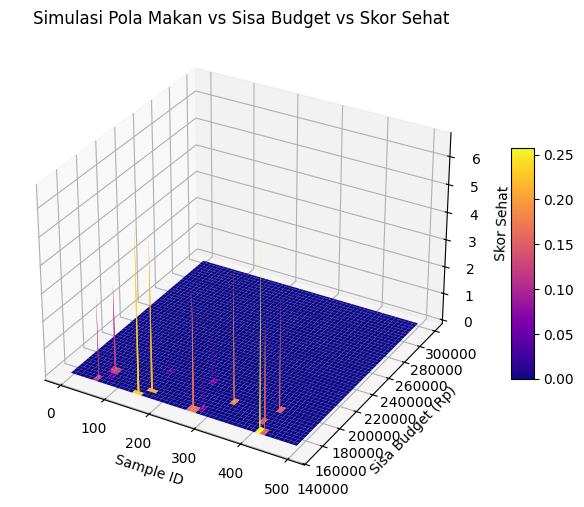

In [29]:
# Visualisasi hasil
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)
surf = ax.plot_surface(X, Y, resp_sehat, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_title("Simulasi Pola Makan vs Sisa Budget vs Skor Sehat", fontsize=12)
ax.set_xlabel("Sample ID")
ax.set_ylabel("Sisa Budget (Rp)")
ax.set_zlabel("Skor Sehat")
plt.show()

**1. Sumbu Grafik**

X (Sample ID) → ini indeks simulasi (0–499). Tiap angka mewakili satu eksperimen pola makan selama 31 hari.

Y (Sisa Budget) → sisa uang (Rp) setelah 31 hari makan, biasanya berkisar antara Rp150.000 – Rp300.000 sesuai batas SISA_MININUM dan SISA_MAKSIMUM.

Z (Skor Sehat) → skor yang dihitung dari kombinasi makanan yang dipilih, dihitung sebagai akumulasi nilai sehat dikurangi baseline (0.5 per makan). Jadi semakin tinggi, artinya semakin sehat.

**2. Makna Warna**

Warna berasal dari cmap='plasma' atau jet_r.

Warna cerah (kuning/merah muda) → skor sehat tinggi.

Warna gelap (ungu/biru tua) → skor sehat rendah.
Dengan kata lain, warna memberi heatmap tambahan untuk membantu membaca grafik.

**3. Interpretasi**

Jika ada pola permukaan naik di arah Z (skor sehat) → berarti ada hubungan positif antara sisa uang dan kesehatan.

Jika permukaan acak/berombak → berarti tidak ada hubungan kuat, karena faktor pemilihan makanan acak lebih dominan.

Kamu bisa lihat bahwa sisa budget lebih sedikit biasanya muncul saat banyak memilih makanan mahal, yang bisa sehat/tidak sehat tergantung menu.

Sisa budget tinggi artinya sering pilih makanan murah (misalnya mie ayam, cireng), tapi bisa jadi skor sehat malah rendah.

**4. Kesimpulan yang Bisa Ditarik**

Trade-off: Semakin hemat (budget akhir besar), belum tentu sehat.

Kesehatan relatif: Skor sehat sangat dipengaruhi oleh proporsi makanan sehat vs tidak sehat, bukan hanya harga.

Variasi antar-sample: Setiap sample ID mewakili simulasi acak, jadi bentuk permukaan tidak mulus → mencerminkan kenyataan bahwa pola makan orang berbeda-beda hasilnya.

In [30]:
#cari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif

idx_sehat_pos = np.where(sehat > 0)[0]
print("Jumlah pola makan dengan skor sehat positif:", len(idx_sehat_pos))

Jumlah pola makan dengan skor sehat positif: 492


In [31]:
#cari titik-titik dengan sisa uang bulanan positif dari (1)

idx_valid = idx_sehat_pos[sisa[idx_sehat_pos] >= 0]
print("Jumlah pola makan sehat & sisa uang positif:", len(idx_valid))

Jumlah pola makan sehat & sisa uang positif: 492


In [32]:
#cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif

idx_sehat_pos = np.where(sehat > 0)[0]
idx_valid = idx_sehat_pos[sisa[idx_sehat_pos] >= 0]

print("\nHasil setelah imputasi harga:")
print("Jumlah pola makan dengan skor sehat > 0:", idx_sehat_pos.size)
print("Jumlah pola makan sehat & sisa >= 0:", idx_valid.size)

if idx_valid.size == 0:
    print("Masih tidak ada sample yang sehat>0 sekaligus sisa>=0 (mungkin budget awal terlalu kecil atau harga makanan terlalu tinggi).")
else:
    best_idx = int(idx_valid[np.argmax(skor[idx_valid])])
    print("best_idx:", best_idx, "skor:", skor[best_idx], "skor_sehat:", sehat[best_idx], "sisa:", sisa[best_idx])


Hasil setelah imputasi harga:
Jumlah pola makan dengan skor sehat > 0: 492
Jumlah pola makan sehat & sisa >= 0: 492
best_idx: 235 skor: 111.28575923878869 skor_sehat: 7.099999999999998 sisa: 71000.0


In [33]:
#Tampilkan jadwal makanan sesuai pilihan (resp_pilih)

jadwal = [makan['makanan'][int(i)] for i in resp_pilih[best_idx]]

for hari in range(31):
    pagi = jadwal[2*hari]
    malam = jadwal[2*hari+1]
    print(f"Hari {hari+1}: Pagi = {pagi}, Malam = {malam}")

Hari 1: Pagi = gado2, Malam = pecel
Hari 2: Pagi = nasigoreng, Malam = mi instan 
Hari 3: Pagi = sate, Malam = soto
Hari 4: Pagi = nasipadang, Malam = warteg
Hari 5: Pagi = sate, Malam = ayam_bakar
Hari 6: Pagi = soto, Malam = gado2
Hari 7: Pagi = soto, Malam = soto
Hari 8: Pagi = ayamgeprek, Malam = sate
Hari 9: Pagi = capcay, Malam = gado2
Hari 10: Pagi = soto, Malam = capcay
Hari 11: Pagi = nasipadang, Malam = sate
Hari 12: Pagi = nasi_uduk, Malam = mieayam
Hari 13: Pagi = soto, Malam = nasi telur
Hari 14: Pagi = soto, Malam = soto
Hari 15: Pagi = ayam_bakar, Malam = nasipadang
Hari 16: Pagi = roti, Malam = ayamgeprek
Hari 17: Pagi = mieayam, Malam = nasigoreng
Hari 18: Pagi = nasi_uduk, Malam = roti
Hari 19: Pagi = nasi_uduk, Malam = soto
Hari 20: Pagi = nasipadang, Malam = nasigoreng
Hari 21: Pagi = soto, Malam = nasi_uduk
Hari 22: Pagi = ayamgeprek, Malam = nasi_uduk
Hari 23: Pagi = nasi_uduk, Malam = ayam_bakar
Hari 24: Pagi = ayam_bakar, Malam = nasigoreng
Hari 25: Pagi = roti,